In [125]:
import chromadb
from datasets import load_dataset
from tqdm import tqdm
import sys
import json
from dataset_embeddings import *
import yaml
import pandas as pd
import matplotlib.pyplot as plt

tqdm.pandas()
sys.path.append("../..")

with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)
RANDOM_SEED = config["RANDOM_SEED"]

# Preapre database and dataset

In [30]:
# Create database and collections
chroma_client = chromadb.PersistentClient("db/")
collection_cosine = chroma_client.get_or_create_collection(
    name="goemotions_train_cosine", metadata={"hnsw:space": "cosine"}
)
collection_inner = chroma_client.get_or_create_collection(
    name="goemotions_train_inner", metadata={"hnsw:space": "l2"}
)

In [3]:
# read the dataset
set_ = "train"
run_number = 3
dataset = load_dataset(
    "go_emotions", "simplified"
)
dataset.set_format(type="pandas")
df = dataset[set_][:]

int2label = lambda x: dataset[set_].features["labels"].feature.int2str(x)
df["labels_text"] = df["labels"].apply(int2label)

In [64]:
# read the new dataset
df_new = pd.read_csv("../cleaning/run1/train_filtered.csv")

# Get embedddings and create DBs

In [4]:
tokenizer, model = init_model()

/Users/usamaahmed/miniconda3/envs/LEGO/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
<All keys matched successfully>


model running on mps


In [5]:
# run embedding model
batch_size = 64
embeddings = []
# iterate through the dataset
for i in tqdm(range(0, len(df), batch_size)):
    batch = list(df.iloc[i : i + batch_size]["text"])
    embeddings += (get_text_embeddings(batch, model, tokenizer, batch = True))

100%|██████████| 679/679 [02:44<00:00,  4.12it/s]


In [6]:
# insert into the database
for i in tqdm(range(len(df))):
    text = df.iloc[i]["text"]
    embedding = embeddings[i]
    collection_cosine.upsert(
        ids = [str(i)],
        documents = [text],
        embeddings = embedding,
    )


100%|██████████| 43410/43410 [03:06<00:00, 232.46it/s]


In [31]:
# insert into the database
for i in tqdm(range(len(df))):
    text = df.iloc[i]["text"]
    embedding = embeddings[i]
    collection_inner.upsert(
        ids = [str(i)],
        documents = [text],
        embeddings = embedding,
    )


100%|██████████| 43410/43410 [00:46<00:00, 923.70it/s] 


# Extract Duplicates

In [37]:
cosine_dict = {}
inner_dict = {}
thresholds = [0.05, 0.1, 0.15, 0.2, 0.25]
for collection in [collection_cosine, collection_inner]:
    if collection == collection_cosine:
        print("Cosine collection")
    else:
        print("Inner collection")
    for threshold in thresholds:
        print(f"Threshold: {threshold}")
        similars_dict = {}
        for i in tqdm(range(len(df))):
            results = get_similars(df, collection, idx=i, n_results=5)
            distances = [r["distance"] for r in results]
            # any distance < 0.15 is considered similar, add it to the similars_dict with key i
            results_list = [r["idx"] for r in results[1:] if r["distance"] < threshold]
            if results_list:
                similars_dict[i] = results_list
        if collection == collection_cosine:
            cosine_dict[threshold] = similars_dict
        else:
            inner_dict[threshold] = similars_dict

json_dict = {"cosine": cosine_dict, "inner": inner_dict}
with open("duplicates.json", "w") as f:
    json.dump(json_dict, f)

Cosine collection
Threshold: 0.05


100%|██████████| 43410/43410 [01:53<00:00, 383.65it/s]


Threshold: 0.1


100%|██████████| 43410/43410 [01:44<00:00, 414.61it/s]


Threshold: 0.15


100%|██████████| 43410/43410 [01:58<00:00, 367.56it/s]


Threshold: 0.2


100%|██████████| 43410/43410 [01:53<00:00, 381.93it/s]


Threshold: 0.25


100%|██████████| 43410/43410 [01:50<00:00, 391.71it/s]


Inner collection
Threshold: 0.05


100%|██████████| 43410/43410 [01:33<00:00, 462.04it/s]


Threshold: 0.1


100%|██████████| 43410/43410 [01:33<00:00, 463.98it/s]


Threshold: 0.15


100%|██████████| 43410/43410 [01:33<00:00, 463.20it/s]


Threshold: 0.2


100%|██████████| 43410/43410 [01:35<00:00, 455.31it/s]


Threshold: 0.25


100%|██████████| 43410/43410 [01:38<00:00, 441.81it/s]


In [48]:
# Assuming similar_dicts is your dictionary
with open("duplicates.json", "r") as f:
    similars_dict = json.load(f)

cosine_dict, inner_dict = similars_dict["cosine"], similars_dict["inner"]

# convert keys to ints
# similars_dict = {int(k): v for k, v in similars_dict.items()}

# Agreements

In [68]:
from itertools import combinations

def calculate_agreement(list_of_lists):
    def jaccard_similarity(set1, set2):
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        return intersection / union if union else 0
    
    # Convert inner lists to sets
    sets = [set(inner_list) for inner_list in list_of_lists]
    
    # Calculate pairwise Jaccard similarities
    pair_similarities = [jaccard_similarity(s1, s2) for s1, s2 in combinations(sets, 2)]
    
    # Calculate the average similarity
    average_similarity = sum(pair_similarities) / len(pair_similarities) if pair_similarities else 0
    
    return average_similarity

In [69]:
def find_agreement(df, column, similars_dict):
    keys = list(similars_dict.keys())
    agreements = []
    for key in keys:
        indices = list([key]) + similars_dict[key]
        labels = list(df.iloc[indices][column])
        agreements.append(calculate_agreement(labels))
    avg_agreements = sum(agreements) / len(agreements)
    return agreements, avg_agreements

In [120]:
def get_examples(index, duplicates_dict, df = df ,df_new = df_new, df_column = "labels_text", df_new_column = "parsed_predictions"):
    index = list(duplicates_dict.keys())[index]
    indices = [int(index)] + duplicates_dict[index]
    example_text = df.iloc[indices]["text"]
    example_labels = df.iloc[indices][df_column]
    example_new_labels = df_new.iloc[indices][df_new_column]
    # convert these dicts into a dataframe
    examples = pd.DataFrame({"text": example_text, "labels": example_labels, "new_labels": example_new_labels})
    return examples


In [121]:
get_examples(7, cosine_dict['0.25'])

,text,labels,new_labels
30,"Troll, bro. They know they're saying stupid sh...",[anger],"['disapproval', 'anger', 'annoyance']"
18647,Most of the people commenting in /r/Libertaria...,[annoyance],"['anger', 'disapproval', 'annoyance']"


In [132]:
def get_averages(df, column):
    averages_cosine = {}
    agreements_lists_cosine = {}
    for key in cosine_dict.keys():
        similars_dict = cosine_dict[key]
        similars_dict = {int(k): v for k, v in similars_dict.items()}
        agreements, avg_agreements = find_agreement(df, column, similars_dict)
        averages_cosine[key] = avg_agreements
        agreements_lists_cosine[key] = agreements
    averages_inner = {}
    agreements_lists_inner = {}
    for key in inner_dict.keys():
        similars_dict = inner_dict[key]
        similars_dict = {int(k): v for k, v in similars_dict.items()}
        agreements, avg_agreements = find_agreement(df, column, similars_dict)
        averages_inner[key] = avg_agreements
        agreements_lists_inner[key] = agreements
    return averages_cosine, agreements_lists_cosine, averages_inner, agreements_lists_inner

In [135]:
averages_cosine, _, averages_inner, _ = get_averages(df, "labels_text")
averages_cosine_new, _, averages_inner_new, _ = get_averages(df_new, "parsed_predictions")

In [153]:
get_examples(15, cosine_dict['0.25'])

,text,labels,new_labels
55,This isn't really wholesome,[disapproval],"['disapproval', 'disappointment']"
134,This is sort of wholesome in a weird way,[neutral],"['amusement', 'admiration']"
32905,Tell me why it’s not wholesome so I can figure...,[neutral],"['confusion', 'curiosity']"
28289,its pretty wholesome tho,[admiration],"['amusement', 'joy']"
39232,A little weird but I guess it's wholesome.,[approval],"['amusement', 'approval']"


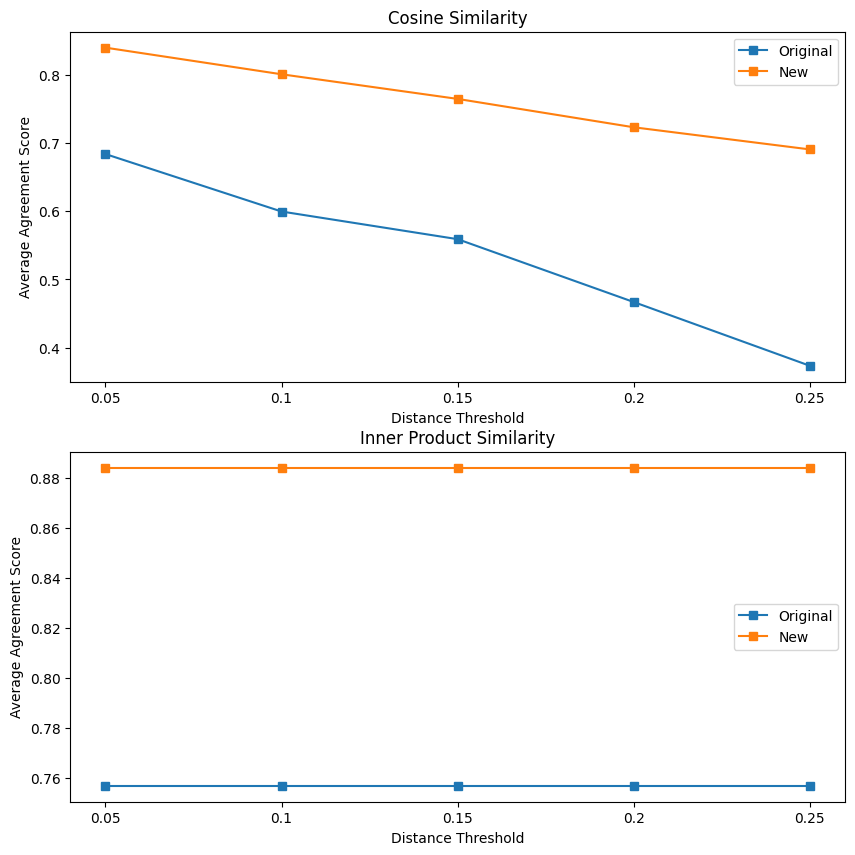

In [154]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes[0].plot(averages_cosine.keys(), averages_cosine.values(), label = "Original", marker = "s")
axes[0].plot(averages_cosine_new.keys(), averages_cosine_new.values(), label = "New", marker = "s")
axes[0].set_xlabel("Distance Threshold")
axes[0].set_ylabel("Average Agreement Score")
axes[0].set_title("Cosine Similarity")
axes[0].legend()
axes[1].plot(averages_inner.keys(), averages_inner.values(), label = "Original", marker = "s")
axes[1].plot(averages_inner_new.keys(), averages_inner_new.values(), label = "New", marker = "s")
axes[1].set_xlabel("Distance Threshold")
axes[1].set_ylabel("Average Agreement Score")
axes[1].set_title("Inner Product Similarity")
axes[1].legend()

# Comment: Inner product is not useful at all in this case
# TODO remove inner product from the database